In [1]:
import numpy as np
import umap.umap_ as umap
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN


/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")
from scripts.nets_and_embeddings import *

In [3]:
params = {
    "N": 100000,
    "k": 50,
    "maxk": 1000,
    "minc": 50,
    "maxc": 1000, #maxc > maxk and minc > mink has to be satisfied.
    "tau": 3.0,
    "tau2": 1.0,
    "mu": 0.10,
}

emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

path_name = "/nobackup/gogandhi/alt_means_sans_k/data/experiment_changing_negative_samples"
net, community_table, emb = create_and_save_network_and_embedding(params, emb_params, path_name=None, save_file=True)
print(len(set(community_table['community_id'])))

319


/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]


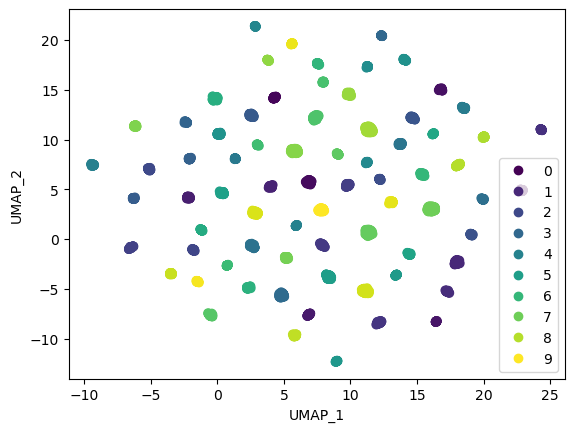

In [15]:
# # BOilerPLate Code for umap
# def umap_plot(data, clusters):
#     embedding = umap.UMAP(random_state=42, metric="euclidean").fit_transform(data) # Use cosine metric too

#     s = plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters, cmap = 'viridis')
#     plt.xlabel('UMAP_1')
#     plt.ylabel('UMAP_2')
#     plt.legend(s.legend_elements()[0], list(set(clusters)))
#     print(list(set(clusters)))
#     #plt.title('UMAP clustering of 4406 cells', fontsize=20)
#     plt.show()
#     return

# umap_plot(emb, node_table['community_id'])

In [ ]:
# # Loading files from lf_sadamori

# #mu_values = np.round(np.arange(0.10, 1.05, 0.05),decimals=2)
# #samples = [0,1,2]
# mu = 0.10
# sample = 0
# print(mu,sample)
# #net_n~
# net_file = f"/nobackup/gogandhi/alt_means_sans_k/data/lfr_sadamori/net_n~10000_k~10_tau~3_tau2~1_minc~50_mu~{mu:.2f}_sample~{sample}.npz"

# node_file = f"/nobackup/gogandhi/alt_means_sans_k/data/lfr_sadamori/node_n~10000_k~10_tau~3_tau2~1_minc~50_mu~{mu:.2f}_sample~{sample}.npz"
# #n~
# emb_file = f"/nobackup/gogandhi/alt_means_sans_k/data/lfr_sadamori/n~10000_k~10_tau~3_tau2~1_minc~50_mu~{mu:.2f}_sample~{sample}_model_name~node2vec_window_length~10_dim~64.npz"

# node_table = pd.read_csv(node_file)
# node_table = node_table.rename(columns={'membership': 'community_id'})
# emb = np.load(emb_file)["emb"]

In [498]:
# We are visualising how different the communities produced by
# Kmeans and the algorithm are compared to the ground truth

# First get clusters for both methods,

from scripts.similarity_scores import *
from sklearn.cluster import KMeans 


X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
X = emb.copy()
kmeans = KMeans(n_clusters= len(set(community_table["community_id"])), random_state=0,max_iter=300, tol=0.001).fit(X)
kmeans_labels = kmeans.labels_
esim_k = calc_esim(community_table["community_id"], kmeans_labels)
print(esim_k)

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.8977849271352101


Okay, now we have embeddings for a network, and the clusters three ways. If we want to see the different ways the clusters have come out. Then use the three clusters on subplots with as much similarity as possible and see the differences

In [15]:
# HEre we are reducing the number of negative samples by a factor 
# TO see if that increases the number of communities that are one on top of each other.
def proposed_labels_mod(num_negative_samples=0.01):
    device_name = "cuda:3"

    rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=350, device = device_name) # this might involve distance metrics
    print(len(cpos),round(len(cpos)*num_negative_samples))

    cneg = np.random.choice(emb.shape[0], round(len(cpos)*num_negative_samples))

    rpos_mod = np.random.choice(rpos, round(len(cpos)*num_negative_samples))

    vneg = np.array(np.sum(emb[rpos_mod, :] * emb[cneg, :], axis=1)).reshape(-1)

    model = LogisticRegression()
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
            )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
    proposed_labels = louvain(emb, w1, b0, device = device_name) # this might involve distance metrics

    return proposed_labels

#labels_neg = {}

for num_negative_samples in [1,0.1,0.01,0.001,0.0001]:
    labels_p = proposed_labels_mod(num_negative_samples)
    esim_p = calc_esim(community_table["community_id"], labels_p)
    labels_neg[num_negative_samples] = labels_p
    print(esim_k, esim_p, num_negative_samples)
    
    

35100000 35100000
0.8977837361873756 0.9864977160648994 1
35100000 3510000
0.8977837361873756 0.9514588635808632 0.1
35100000 351000
0.8977837361873756 0.9235579517760645 0.01
35100000 35100
0.8977837361873756 0.8942544939048467 0.001
35100000 3510
0.8977837361873756 0.881586491963954 0.0001


In [480]:
esim_k

0.8977837361873756

In [335]:
# Untouched method to get clusters
# Increase num_neighbors to reduce communities with 1/2 members

def proposed_method_labels(emb,device_name):
        
        rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=350, device = device_name) # this might involve distance metrics
        cneg = np.random.choice(emb.shape[0], len(cpos))
        vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

        model = LogisticRegression()
        model.fit(
            np.concatenate([vpos, vneg]).reshape((-1, 1)),
            np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
                )
        w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
        return louvain(emb, w1, b0, device = device_name) # this might involve distance metrics

proposed_labels = proposed_method_labels(emb,"cuda:3")
esim_p = calc_esim(community_table["community_id"], proposed_labels)
print(esim_p)

(0.9858329508657075, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))


In [8]:
# Reduce dimensions using UMAP
embedding_euc = umap.UMAP(random_state=42).fit_transform(emb)
embedding_cos = umap.UMAP(random_state=42,metric="cosine").fit_transform(emb)

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [24]:
esims = {"kmeans":0.898,
         1: 0.986,
         0.1: 0.951,
         0.01: 0.924 ,
         0.001: 0.894 ,
         0.0001: 0.881}

305
319


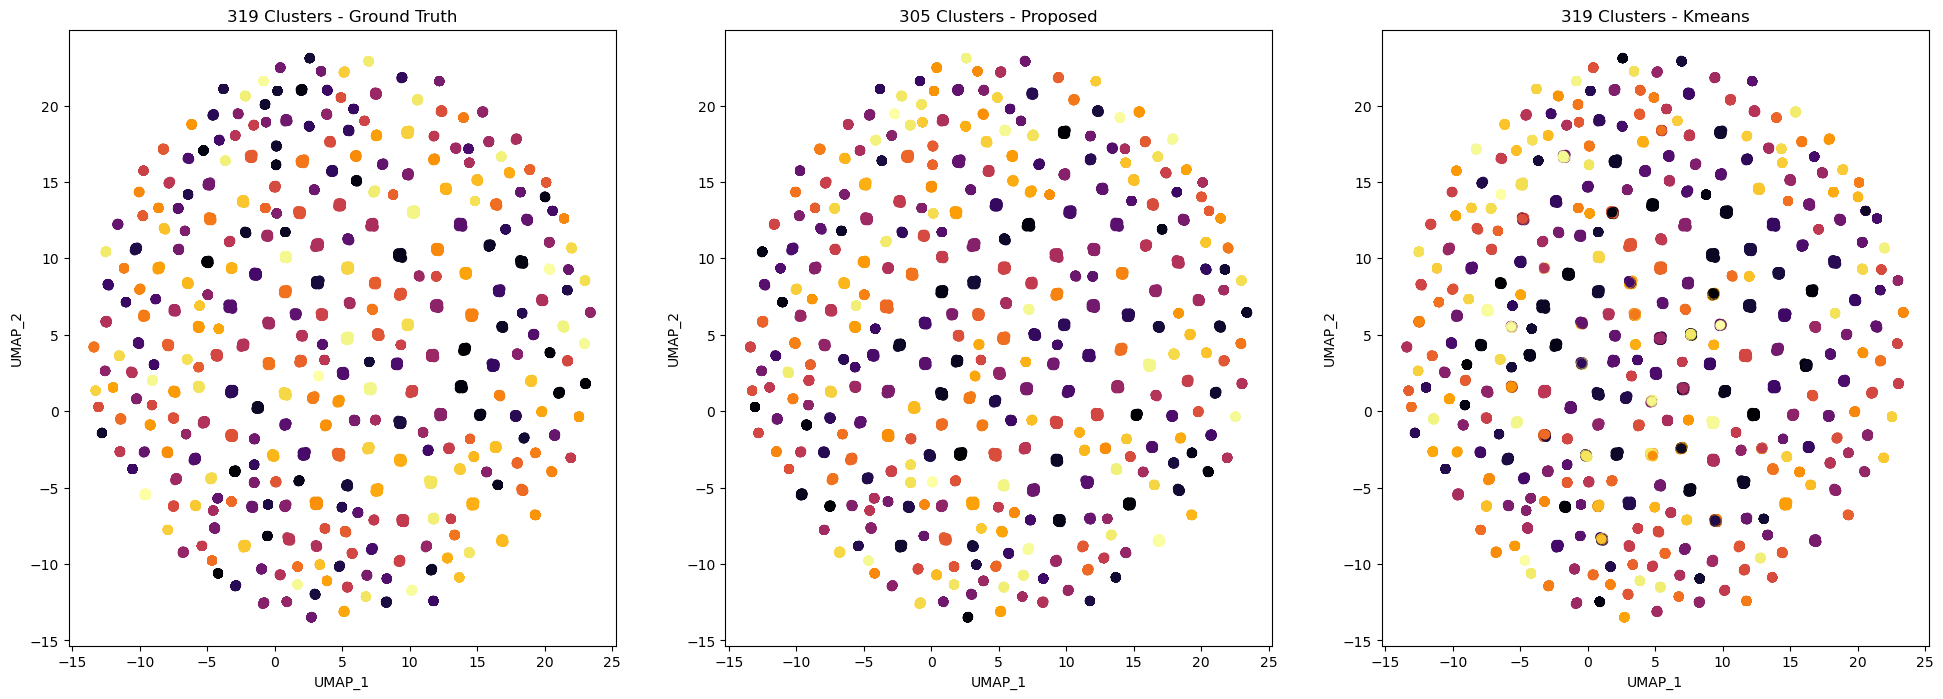

In [10]:
import copy
embedding = copy.deepcopy(embedding_cos)
fig, ax = plt.subplots(1,3,figsize=(24,8))
cmap='inferno'
g = ax[0].scatter(embedding[:, 0], embedding[:, 1], c = community_table['community_id'], cmap = cmap)
k = ax[2].scatter(embedding[:, 0], embedding[:, 1], c = kmeans_labels, cmap = cmap)
p = ax[1].scatter(embedding[:, 0], embedding[:, 1], c = proposed_labels, cmap = cmap)
for i in range(3):
    ax[i].set_xlabel('UMAP_1')
    ax[i].set_ylabel('UMAP_2')
#ax[0].set_legend(s.legend_elements()[0], list(set(clusters)))
ax[0].set_title(f"{len(set(community_table['community_id']))} Clusters - Ground Truth")
ax[1].set_title(f"{len(set(proposed_labels))} Clusters - Proposed")
ax[2].set_title(f"{len(set(kmeans_labels))} Clusters - Kmeans")

print(len(set(proposed_labels)))
print(len(set(kmeans_labels)))
#plt.title('UMAP clustering of 4406 cells', fontsize=20)
plt.show()

In [13]:
community_table["community_id"], kmeans_labels

(0         79
 1         76
 2         56
 3        181
 4         76
         ... 
 99995    241
 99996    146
 99997     80
 99998     50
 99999    134
 Name: community_id, Length: 100000, dtype: int64,
 array([108,  72,  18, ...,  21, 160, 181], dtype=int32))

Btw, could you check the following to better understand hte problem?  
Distance between the detected clusters by the K-means only for the misidentified ones.  
Size of the detected clusters only for the misidentifeid ones.  
Average degree of the nodes in these misidentified clusters.  
 
Distance in terms of average Euclidean and Cosine distances between two nodes in different detected clusters.



In [17]:
# For the above, we need the misidentified clusters. i.e. we are giving input y, ypred to calc_esim
# we want an average point for each cluster. Average embeddings of each cluster from ground truth
# we want the id's of the clusters that were misidentified from kmeans, DONE
# and their average coordinates
# We want what the id's were supposed to be according to ground truth. DONE
# we would by extension want the nodes belonging to the misidentified cluster ids of kmeans

# how to mod kmeans for that?


In [499]:
import numpy as np
from scipy import sparse

def calc_esim(y, ypred):
    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)
    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
   
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected, nAB

# Example usage:
#y_true = np.array([59, 59, 101, 10, 101, 101])
#y_pred = np.array([1, 1, 2, 3, 2, 3])

y_true= copy.deepcopy(community_table['community_id'])
y_pred = copy.deepcopy(kmeans_labels)
#y_pred = copy.deepcopy(proposed_labels)

esim_score, nAB = calc_esim(y_true, y_pred)

print("Element-centric similarity:", esim_score)


Element-centric similarity: 0.8977849271352101


In [500]:
# y_true= copy.deepcopy(community_table['community_id'])
# y_pred = copy.deepcopy(kmeans_labels)
# y_prop = copy.deepcopy(proposed_labels)

yclab, yc = np.unique(y_true, return_inverse=True)
ypclab, ypc = np.unique(y_pred, return_inverse=True)

misclass_dict = {} # Key is ground truth label, values are predicted labels which were classified as given ground truth
for i in range(len(nAB)):
    x = np.where(nAB[i]!=0)[0]
    if len(x)!=1:
        misclass_dict[yclab[i]] = ypclab[x]
        print(yclab[i],ypclab[x])
#         set_combined = ()
#         for j in ypclab[x]:
#             set_combined = set(set_combined).union(set(list(proposed_cluster_nodes[j][0])))
#         print(yclab[i],ypclab[x], set(list(ground_truth_cluster_nodes[yclab[i]]))==set_combined )
        

34 [ 65 258]
54 [128 219]
56 [ 3 18]
66 [ 22  68 128 218 265 275]
119 [ 77 267]
139 [ 87 265]
153 [152 232]
159 [ 46 273]
165 [ 39 233]
171 [166 256]
177 [223 276]
193 [ 38 213]
194 [ 10 197]
196 [  6 263]
197 [ 25 297]
200 [ 97 311]
203 [32 41]
211 [239 298]
220 [ 50 303]
225 [ 58 189]
246 [115 307]
247 [111 314]
264 [154 310]
266 [ 47 295]
284 [ 22 248]
291 [ 86 318]
295 [107 242]
306 [ 68 127]
309 [ 35 130]
310 [ 26 140]


In [501]:
# For each key in dict, we take the centroid of that vectors in that cluster.
# we do the same for each of the values. The difference comes from the nodes belonging to that cluster.
# Once done, we can calculate euclidean distances, cosine, degree etc,
ground_truth_cluster_nodes={}
for key in misclass_dict.keys():
    ground_truth_cluster_nodes[key] = list(community_table[community_table['community_id']==key]['node_id'])

kmeans_cluster_nodes={}
for values in misclass_dict.values():
    for value in values:
        kmeans_cluster_nodes[value] = (np.where(kmeans_labels==value)[0])

In [458]:
set(list(ground_truth_cluster_nodes[34])) == set(list(kmeans_cluster_nodes[65])).union(set(list(kmeans_cluster_nodes[258])))

True

In [ ]:
# Centroids for each cluster, gt or kmeans

In [502]:
from scipy.spatial.distance import cosine

def metric(arrays ,metric):
    if len(arrays) ==2:
        vector1 = arrays[0]
        vector2 = arrays[1]

    if metric=='centroid':
            stacked_arrays = np.vstack(arrays)
            centroid = np.mean(stacked_arrays, axis=0)
            return centroid
    if metric=='euclidean':
        
        euclidean_distance = np.linalg.norm(vector1 - vector2)
        return euclidean_distance
    if metric=='cosine':
        return  1 - cosine(vector1, vector2)
    if metric == 'dot':
        return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    
    
    
ground_truth_centroids = {}
for key in ground_truth_cluster_nodes.keys():
    vectors_of_nodes = [emb[i] for i in ground_truth_cluster_nodes[key]]
    ground_truth_centroids[key] = metric(vectors_of_nodes, 'centroid')
    
    
kmeans_centroids={}

for key in kmeans_cluster_nodes.keys():
    vectors_of_nodes = [emb[i] for i in kmeans_cluster_nodes[key]]
    kmeans_centroids[key] = metric(vectors_of_nodes, 'centroid')
    


# Distance between the misclassified kmeans and ground truth:
distances_mis={'euclidean':[], 'cosine':[], 'dot':[]}
for key, values in misclass_dict.items():
    for metrics in ['euclidean','cosine','dot']:
        dists_temp = []
        for value in values:
            dists_temp.append(round(metric([ground_truth_centroids[key],kmeans_centroids[value]],metrics),4))
        distances_mis[metrics].append(dists_temp)


In [503]:
distances_mis['euclidean']

[[0.2152, 0.222],
 [0.3595, 0.1742],
 [0.2705, 0.1746],
 [3.2251, 2.8655, 3.591, 3.3347, 3.2528, 3.7557],
 [0.4094, 0.1304],
 [0.1858, 0.2599],
 [0.5339, 0.1016],
 [0.2447, 0.2094],
 [0.2179, 0.2164],
 [0.2731, 0.2511],
 [0.2646, 0.1923],
 [0.264, 0.1886],
 [0.2313, 0.2048],
 [0.2711, 0.1664],
 [0.2353, 0.2071],
 [0.2359, 0.2088],
 [2.6197, 3.3858],
 [0.2534, 0.184],
 [0.2205, 0.2218],
 [0.2367, 0.2062],
 [0.346, 0.1621],
 [0.2698, 0.2086],
 [0.3168, 0.1993],
 [0.3115, 0.166],
 [0.2725, 0.1926],
 [0.2363, 0.2075],
 [0.2274, 0.2595],
 [2.698, 3.2035],
 [0.2867, 0.1523],
 [0.2375, 0.1955]]

In [504]:
distances_mis['cosine']

[[0.9974, 0.9973],
 [0.9939, 0.9986],
 [0.996, 0.9983],
 [0.5343, 0.5968, 0.4447, 0.4937, 0.5232, 0.3591],
 [0.9918, 0.9992],
 [0.9982, 0.9964],
 [0.9862, 0.9995],
 [0.9968, 0.9977],
 [0.9974, 0.9974],
 [0.9964, 0.9969],
 [0.9962, 0.998],
 [0.9961, 0.998],
 [0.9971, 0.9977],
 [0.9961, 0.9985],
 [0.997, 0.9977],
 [0.997, 0.9976],
 [0.6831, 0.4525],
 [0.9964, 0.9981],
 [0.9974, 0.9973],
 [0.997, 0.9977],
 [0.9939, 0.9987],
 [0.9963, 0.9978],
 [0.9953, 0.9981],
 [0.9949, 0.9985],
 [0.9961, 0.9981],
 [0.9971, 0.9978],
 [0.9974, 0.9966],
 [0.6403, 0.5223],
 [0.9954, 0.9987],
 [0.9969, 0.9979]]

In [496]:
distances_mis['dot']

[[0.9974, 0.9973],
 [0.9939, 0.9986],
 [0.996, 0.9983],
 [0.5343, 0.5968, 0.4447, 0.4937, 0.5232, 0.3591],
 [0.9918, 0.9992],
 [0.9982, 0.9964],
 [0.9862, 0.9995],
 [0.9968, 0.9977],
 [0.9974, 0.9974],
 [0.9964, 0.9969],
 [0.9962, 0.998],
 [0.9961, 0.998],
 [0.9971, 0.9977],
 [0.9961, 0.9985],
 [0.997, 0.9977],
 [0.997, 0.9976],
 [0.6831, 0.4525],
 [0.9964, 0.9981],
 [0.9974, 0.9973],
 [0.997, 0.9977],
 [0.9939, 0.9987],
 [0.9963, 0.9978],
 [0.9953, 0.9981],
 [0.9949, 0.9985],
 [0.9961, 0.9981],
 [0.9971, 0.9978],
 [0.9974, 0.9966],
 [0.6403, 0.5223],
 [0.9954, 0.9987],
 [0.9969, 0.9979]]

In [497]:
for key, values in misclass_dict.items():
    avg_deg_gt = round(np.mean([np.sum(net[node]) - 1 for node in ground_truth_cluster_nodes[key]]),2)
    nodes = [kmeans_cluster_nodes[value][0] for value in values]
    avg_deg_km = []
    for nodeclus in nodes:
        arr=[]
        for node in nodeclus:
            arr.append(np.sum(net[node])-1)
        avg_deg_km.append(round(np.mean(arr),2))
    #avg_deg_km = 
    print("gt: ", avg_deg_gt , "kmeans: ", avg_deg_km)

TypeError: 'numpy.int64' object is not iterable

In [ ]:
for key, values in misclass_dict.items():
    print("gt: ", len(ground_truth_cluster_nodes[key]), "kmeans: ", [len(kmeans_cluster_nodes[elm][0]) for elm in values])

In [165]:
misclass_dict[34],

(array([ 65, 258], dtype=int32), 54.20996441281139)

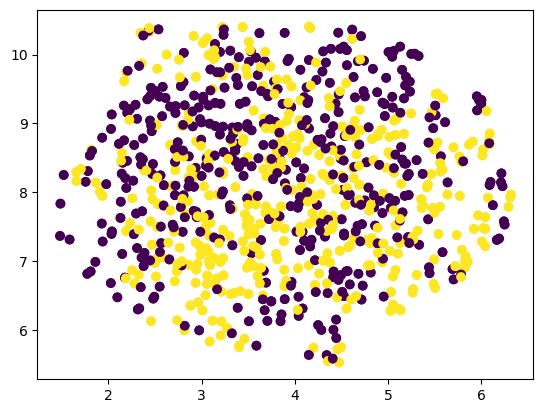

In [470]:
# Why does Kmeans not work? Let's look at GT:  34 Kmeans: [ 65 258]
# let's visualize the vectors belonging to gt cluster 34
# Vectors of ground truth cluster 34. If we run 
#emb[ground_truth_cluster_nodes[34]]

#embedding = umap.UMAP(random_state=42, metric="euclidean").fit_transform(emb[ground_truth_cluster_nodes[34]]) # Use cosine metric too
#clusters = [1]*len(embedding)
s = plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters, cmap = 'viridis')# # BOilerPLate Code for umap
clusters= []
for node in ground_truth_cluster_nodes[34]:
    if node in kmeans_cluster_nodes[65]:
        clusters.append(65)
    else:
        clusters.append(258)
s = plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters, cmap = 'viridis')# # BOilerPLate Code for umap
# def umap_plot(data, clusters):
#     embedding = umap.UMAP(random_state=42, metric="euclidean").fit_transform(data) # Use cosine metric too

#     s = plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters, cmap = 'viridis')
#     plt.xlabel('UMAP_1')
#     plt.ylabel('UMAP_2')
#     plt.legend(s.legend_elements()[0], list(set(clusters)))
#     print(list(set(clusters)))
#     #plt.title('UMAP clustering of 4406 cells', fontsize=20)
#     plt.show()
#     return

# umap_plot(emb, node_table['community_id'])

In [478]:
metric([kmeans_centroids[65], np.zeros(64)],'euclidean') - metric([np.zeros(64), kmeans_centroids[258]],'euclidean')

-0.008197735619515534

In [197]:
avgd = []
for i in range(np.shape(net)[0]):
    avgd.append(np.sum(net[i]))
np.mean(avgd)

49.71322

(array([30., 21., 23., 23., 11., 21., 20.,  7.,  9., 11.,  5.,  6., 10.,
         4.,  5.,  9.,  5.,  1.,  5.,  5.,  8.,  6.,  0.,  3.,  1.,  2.,
         4.,  3.,  4.,  2.,  2.,  4.,  4.,  5.,  3.,  3.,  0.,  2.,  1.,
         2.,  4.,  5.,  6.,  2.,  3.,  2.,  1.,  3.,  2.,  1.]),
 array([ 50. ,  68.8,  87.6, 106.4, 125.2, 144. , 162.8, 181.6, 200.4,
        219.2, 238. , 256.8, 275.6, 294.4, 313.2, 332. , 350.8, 369.6,
        388.4, 407.2, 426. , 444.8, 463.6, 482.4, 501.2, 520. , 538.8,
        557.6, 576.4, 595.2, 614. , 632.8, 651.6, 670.4, 689.2, 708. ,
        726.8, 745.6, 764.4, 783.2, 802. , 820.8, 839.6, 858.4, 877.2,
        896. , 914.8, 933.6, 952.4, 971.2, 990. ]),
 <BarContainer object of 50 artists>)

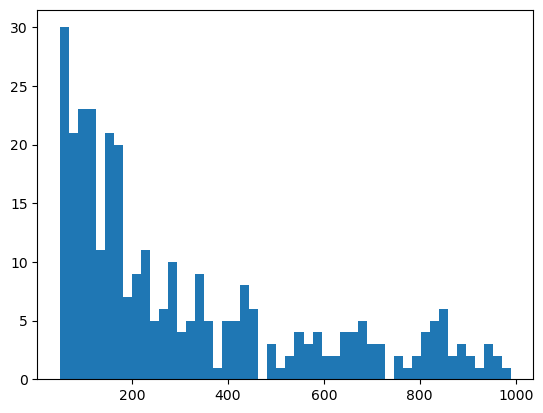

In [202]:
ue, ct = np.unique(community_table['community_id'], return_counts=True)
plt.hist(ct,bins=50)

(0.0, 250.0)

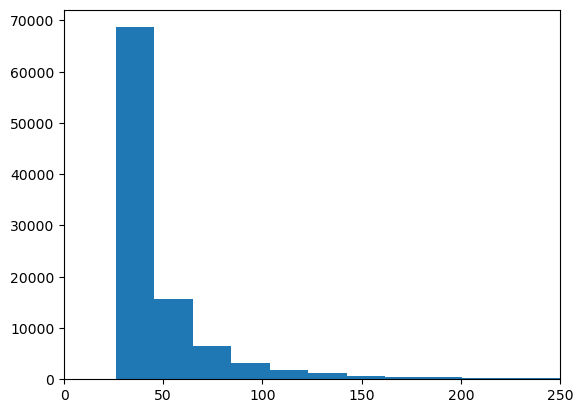

In [211]:

plt.hist(avgd,50)
plt.xlim(0,250)

In [86]:
yclab[2], [ypclab[i] for i in nAB[2][[1,2]]]

(101, [3, 2])

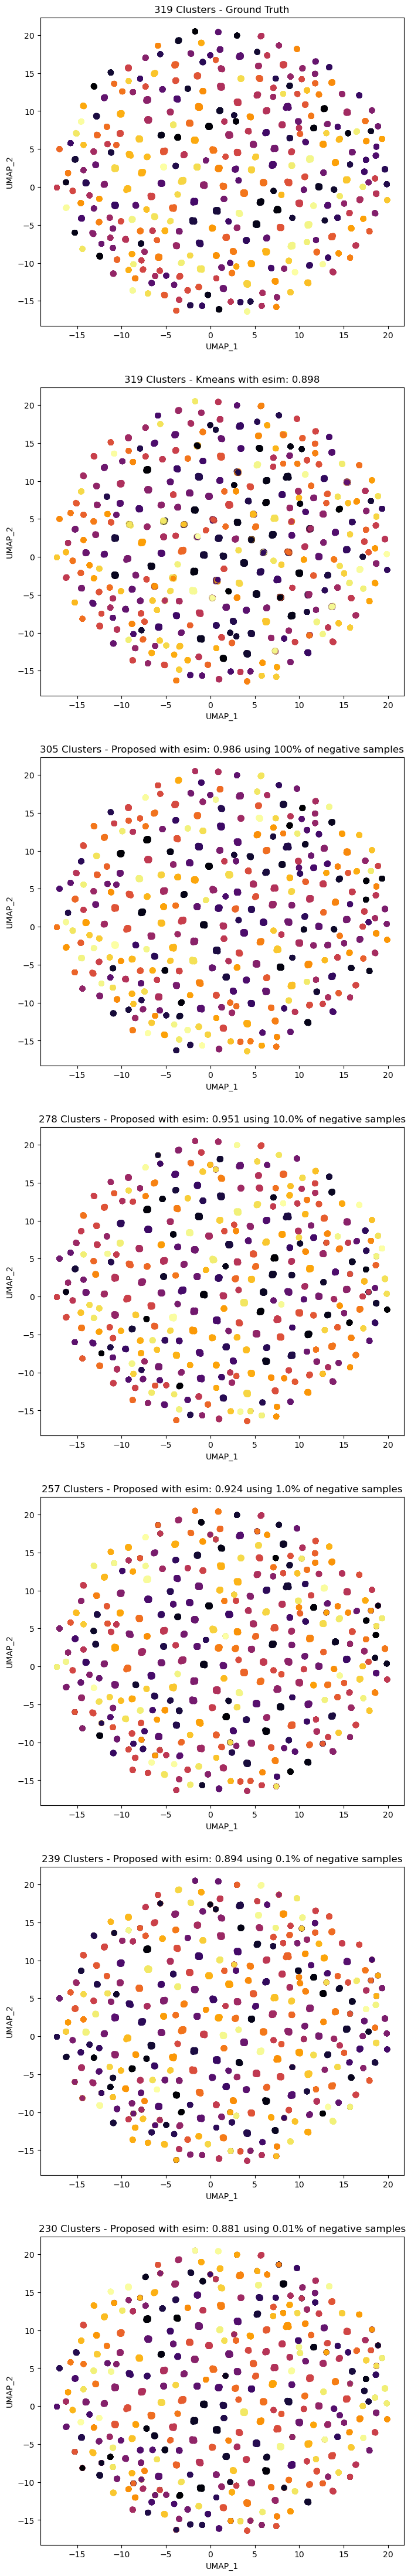

In [29]:
# PLotting using both metrics
import copy

fig, ax = plt.subplots(7,figsize=(8,8*7))

i=0
embedding = copy.deepcopy(embedding_euc) if i==0 else copy.deepcopy(embedding_cos)

cmap='inferno'
ax[0].scatter(embedding[:, 0], embedding[:, 1], c = community_table['community_id'], cmap = cmap)
ax[0].set_title(f"{len(set(community_table['community_id']))} Clusters - Ground Truth")

ax[1].scatter(embedding[:, 0], embedding[:, 1], c = kmeans_labels, cmap = cmap)
ax[1].set_title(f"{len(set(kmeans_labels))} Clusters - Kmeans with esim: {esims['kmeans']}")

for i,j in enumerate(labels_neg.keys()):

    ax[i+2].scatter(embedding[:, 0], embedding[:, 1], c = labels_neg[j], cmap = cmap)
    ax[i+2].set_title(f"{len(set(labels_neg[j]))} Clusters - Proposed with esim: {esims[j]} using {j*100}% of negative samples")
#ax[0].set_legend(s.legend_elements()[0], list(set(clusters)))
    

for a in ax:
    a.set_xlabel('UMAP_1')
    a.set_ylabel('UMAP_2')

#plt.title('UMAP clustering of 4406 cells', fontsize=20)
plt.show()

280
282


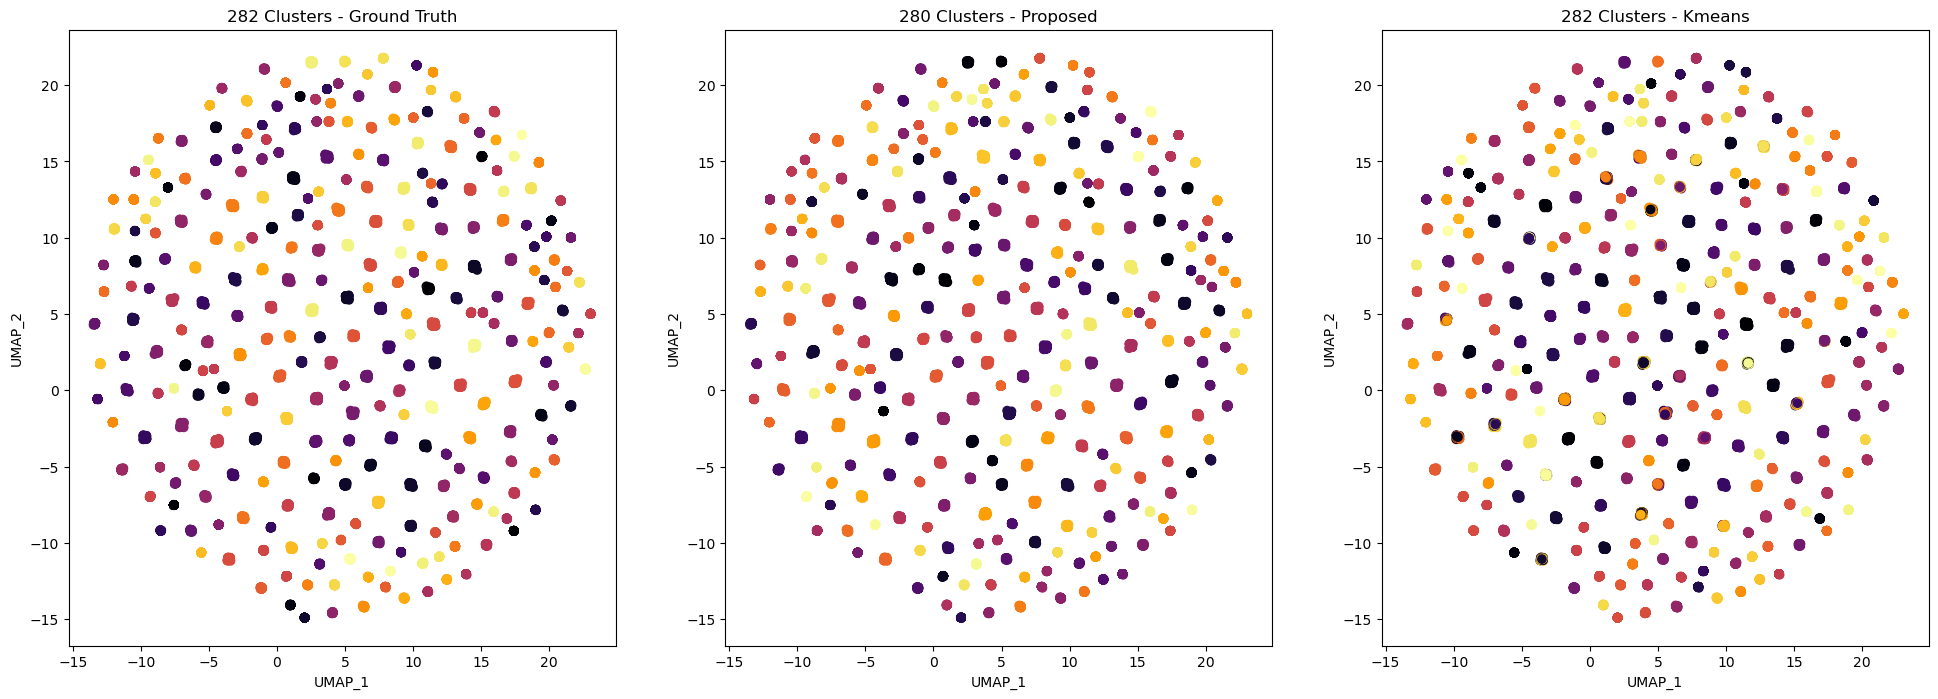